# Base Case: Circular Orbit of Radius 1 AU, Period 1 Year

Create synthetic data for the simplest base case: a circular orbit of radius 1.

Can think of this as approximating the earth: radius = 1 AU, period = 1 year, mass of sun $m_0$ = 1 solar mass

\begin{align}
x(t) &= \cos(\omega t) \\
y(t) &= \sin(\omega t) \\
\omega &= 2 \pi
\end{align}

Taking two derivatives
\begin{align}
\ddot{x}(t) = -\omega^2 x(t)\\
\ddot{y}(t) = -\omega^2 y(t)
\end{align}

Equating the acceleration $\omega^2 r$ to $G \cdot m_0 / r^2$ for $r=1$ in the case of earth, we can see that in these units the gravitational constant $G$ is
$$G = 4 \pi^2$$

Further we can see that for a planet in a circular orbit with radius $r$, the angular frequency will satisfy
$$ \omega^2 = G m_0 / r^3$$
This is a special case of Kepler's third law.

In [1]:
# Library imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# Aliases
keras = tf.keras

In [2]:
# Local imports
from utils import gpu_grow_memory, TimeHistory
from utils import load_vartbl, save_vartbl, plot_style

from r2b_data import make_traj_r2bc , make_train_r2bc
from r2b_data import plot_orbit_q, plot_orbit_v, plot_orbit_a, plot_orbit_energy
from r2b_data import make_datasets_earth, make_datasets_solar
from r2bc_model import make_model_r2bc, make_model_r2bc_math

In [3]:
# Grow GPU memory (must be first operation in TF)
gpu_grow_memory()

In [4]:
# Create distribution strategy
# This isn't working properly for training in Michael-PC (Windows 10)
# but does work for evaluating (with no real benefit though)
# strat = tf.distribute.MirroredStrategy(['/GPU:0', '/GPU:1'])

# Plot style 
plot_style()

In [5]:
# Lightweight serialization
fname = '../pickle/r2bc.pickle'
vartbl = load_vartbl(fname)

In [6]:
# One trajectory of earth for plotting
inputs_earth, outputs_earth = make_traj_r2bc(r=1.0, theta0=0.0, n_years=2)

# Combined dict
data_earth = {**inputs_earth, **outputs_earth}

In [7]:
# fig, ax = plot_orbit_q(data_earth)

In [8]:
# fig, ax = plot_orbit_v(data_earth)

In [9]:
# fig, ax = plot_orbit_a(data_earth)

In [10]:
# fig, ax = plot_orbit_energy(data_earth)

In [11]:
# Create DataSet objects for toy size problem - earth orbits only (a=1, e=0)
ds_earth_trn, ds_earth_val, ds_earth_tst = make_datasets_earth(n_traj=1000, vt_split=0.20)

# Create DataSet objects for solar system type orbits (a between 0.25 and 32.0)
# ds_solar_trn, ds_solar_val, ds_solar_tst = make_datasets_solar(n_traj=10000, vt_split=0.20)

In [12]:
optimizer = keras.optimizers.Adam()

loss = {'q': keras.losses.MeanSquaredError(name='q_mse'),
        'v': keras.losses.MeanSquaredError(name='q_mse'),
        'a': keras.losses.MeanSquaredError(name='a_mse'),
        'q0_rec': keras.losses.MeanSquaredError(name='q0_mse'),
        'v0_rec': keras.losses.MeanSquaredError(name='v0_mse')}

# these metrics produce crazy output names when multiple instances share them; hold off for now
# metrics = {'q': keras.metrics.MeanAbsoluteError(name='q_mae'),
#            'v': keras.metrics.MeanAbsoluteError(name='v_mae')}
metrics = None

loss_weights = {'q': 1.0,
                'v': 1.0,
                'a': 0.0,
                'q0_rec': 1.0,
                'v0_rec': 1.0}

In [13]:
# Compile the mathematical model on a single GPU
model_math = make_model_r2bc_math()
model_math.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [14]:
# Compile the mathematical model for parallel GPUs
# with strat.scope():
#     model_math_par = make_model_r2bc_analytic()
#     model_math_par.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [15]:
# Timing baseline for analytic model, single GPU
# model_math.evaluate(ds_trn.take(5000))
trials = np.array([32.438, 32.220, 31.399, 31.492, 32.038])
time_mean = np.mean(trials)
time_std = np.std(trials)
print(f'Mean time:  {time_mean:5.3f}')
print(f'Stdev time: {time_std:5.3f}')

Mean time:  31.917
Stdev time: 0.407


In [16]:
def time_model_eval(model, ds, batches=None, time_mean=None):
    """Time a model to evaluate a dataset"""
    t0 = time.time()
    if batches is None:
        model.evaluate(ds)
    else:
        model.evaluate(ds.take(batches))
    t1 = time.time()
    elapsed = t1 - t0
    print(f'Elapsed Time: {elapsed:5.3f} sec')
    if time_mean is not None:
        delta = (elapsed - time_mean)
        print(f'Time Delta:   {delta:+5.3f} sec')

In [18]:
# Time the single GPU math model
# time_model_eval(model_math, ds_earth_trn)

In [19]:
# Time the double GPU math model
# time_model_eval(model_math_par, ds_earth_trn)

In [20]:
# keras.utils.plot_model(model_math, show_shapes=False)

In [21]:
# model_math.summary()

In [68]:
def make_model_r2bc():
    """Create a model for the restricted two body circular problem"""
    # Create input layers
    t = keras.Input(shape=(1,), name='t')
    q0 = keras.Input(shape=(2,), name='q0')
    v0 = keras.Input(shape=(2,), name='v0')
    # The combined input layers
    inputs = [t, q0, v0]
    
    # Combine the input features for the initial configuration
    config0 = keras.layers.concatenate(inputs=[q0, v0], name='config0') 

    # 2 Dense feature layers depending ONLY on the configuration (not the time)
    phi_1 = keras.layers.Dense(units=4, activation='relu', name='phi_1')(config0)
    phi_1 = keras.layers.concatenate(inputs=[config0, phi_1], name='phi_1_aug')
    phi_2 = keras.layers.Dense(units=4, activation='relu', name='phi_2')(phi_1)
    phi_2 = keras.layers.concatenate(inputs=[phi_1, phi_2], name='phi2_aug')
    
    # The radius r; this is the same at time 0 and t because phi_2 does not depend on t
    # r = keras.layers.Dense(1, name='r')(phi_2)
    r = tf.norm(q0, axis=1)
  
    # The angular velocity omega
    omega = keras.layers.Dense(1, name='omega')(phi_2)
    
    # Negative of omega and omega2; used below for computing the velocity and acceleration components
    neg_omega = keras.layers.Activation(activation=tf.negative, name='neg_omega')(omega)
    neg_omega2 = keras.layers.multiply(inputs=[neg_omega, omega], name='neg_omega2')
    
    # The initial angle theta_0
    # theta0 = keras.layers.Dense(1, name='theta0')(phi_2)
    
    # Slice out x and y from a 2D vector
    slice_x = lambda q : tf.slice(q, [0, 0], [-1, 1]) 
    slice_y = lambda q : tf.slice(q, [0, 1], [-1, 1]) 
    
    # Extract x and y from q0
    q0x = keras.layers.Lambda(slice_x, name='q0x')(q0)
    q0y = keras.layers.Lambda(slice_y, name='q0y')(q0)
    
    # The initial angle theta0
    theta0 = tf.atan2(q0y, q0x, name='theta0')
    
    # The angle theta at time t
    omega_t = keras.layers.multiply(inputs=[omega, t], name='omega_t')
    theta = keras.layers.add(inputs=[omega_t, theta0], name='theta')
    
    # Cosine and sine of theta
    cos_theta = keras.layers.Activation(activation=tf.cos, name='cos_theta')(theta)
    sin_theta = keras.layers.Activation(activation=tf.sin, name='sin_theta')(theta)

    # Compute qx and qy from r, theta
    qx = keras.layers.multiply(inputs=[r, cos_theta], name='qx')
    qy = keras.layers.multiply(inputs=[r, sin_theta], name='qy')
    q = keras.layers.concatenate(inputs=[qx, qy], name='q')
    
    # Compute vx and vy from r, theta
    vx = keras.layers.multiply(inputs=[neg_omega, qy], name='vx')
    vy = keras.layers.multiply(inputs=[omega, qx], name='vy')
    v = keras.layers.concatenate(inputs=[vx, vy], name='v')

    # Compute ax and ay from r, theta
    ax = keras.layers.multiply(inputs=[neg_omega2, qx], name='ax')
    ay = keras.layers.multiply(inputs=[neg_omega2, qy], name='ay')
    a = keras.layers.concatenate(inputs=[ax, ay], name='a')

    # The sine and cosine of theta0 are used for the recovered initial configuration
    cos_theta0 = keras.layers.Activation(activation=tf.cos, name='cos_theta0')(theta0)
    sin_theta0 = keras.layers.Activation(activation=tf.sin, name='sin_theta0')(theta0)

    # The recovered initial position q0_rec
    qx0_rec = keras.layers.multiply(inputs=[r, cos_theta0], name='qx0_rec')
    qy0_rec = keras.layers.multiply(inputs=[r, sin_theta0], name='qy0_rec')
    q0_rec = keras.layers.concatenate(inputs=[qx0_rec, qy0_rec], name='q0_rec')

    # The recovered initial velocity v0_rec
    vx0_rec = keras.layers.multiply(inputs=[neg_omega, qy0_rec], name='vx0_rec')
    vy0_rec = keras.layers.multiply(inputs=[omega, qx0_rec], name='vy0_rec')
    v0_rec = keras.layers.concatenate(inputs=[vx0_rec, vy0_rec], name='v0_rec')       

    # The combined output layers
    outputs = [q, v, a, q0_rec, v0_rec]
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='r2bc')
    return model

In [69]:
# Make the main r2bc model
model = make_model_r2bc()

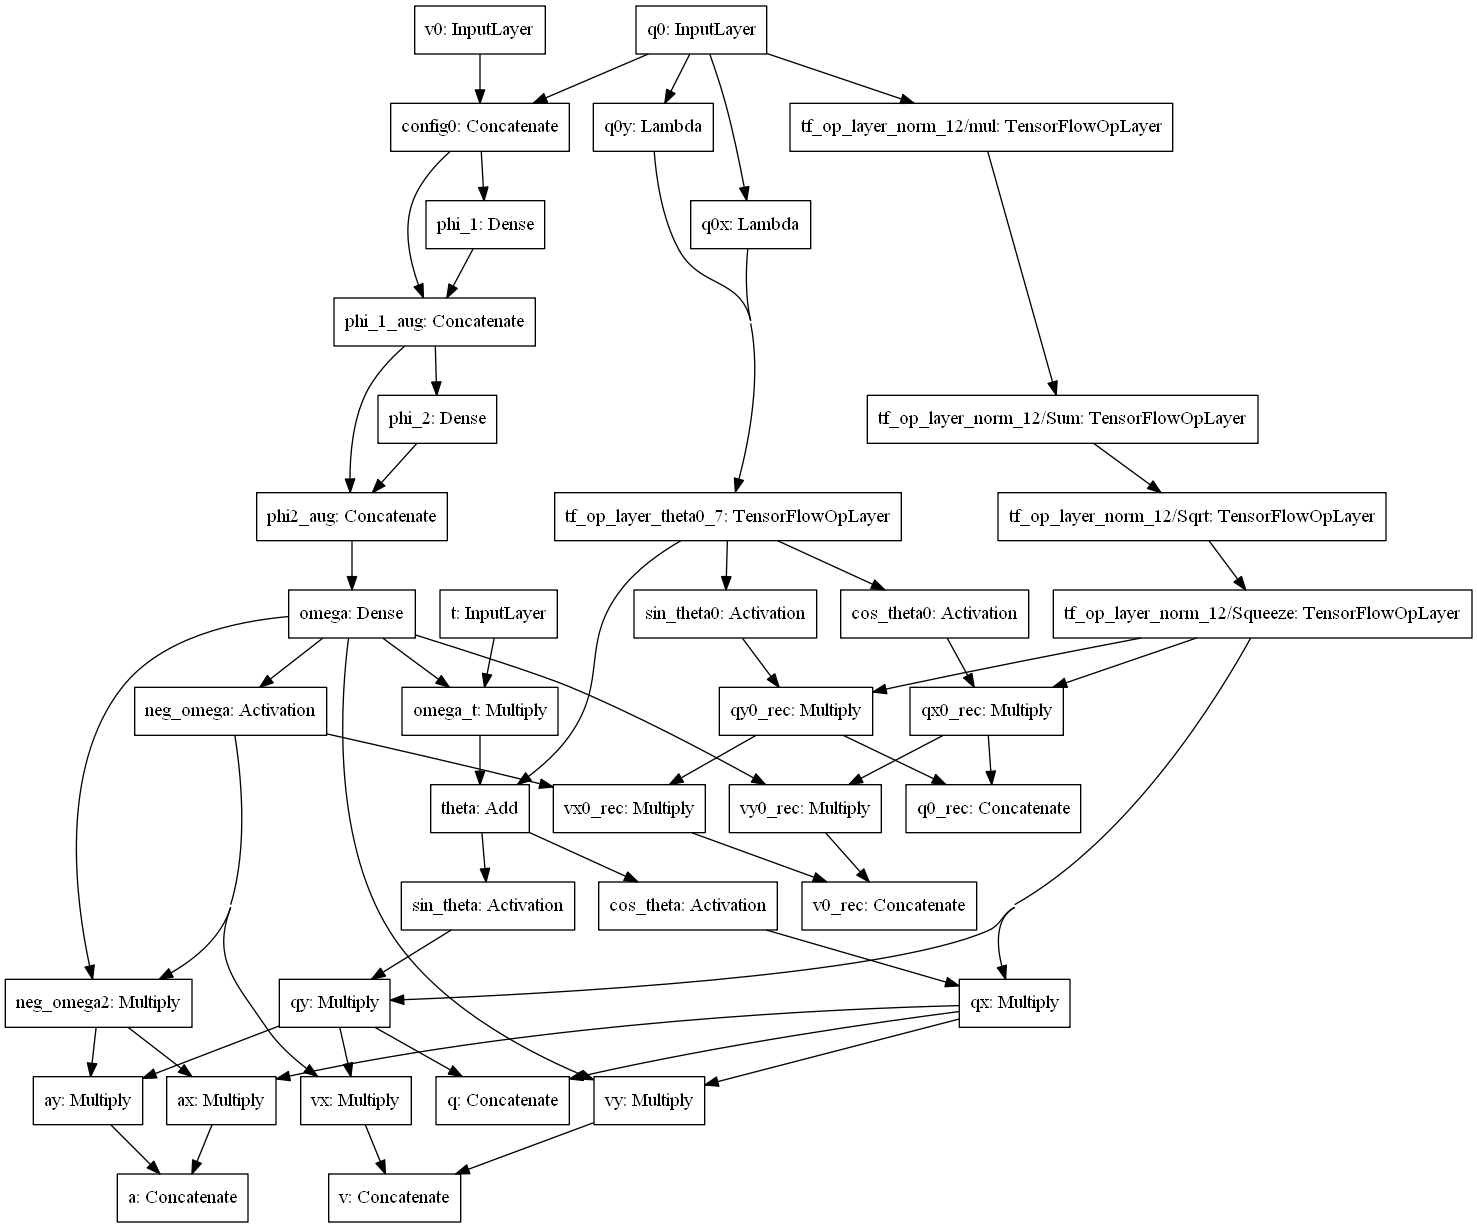

In [70]:
keras.utils.plot_model(model, show_shapes=False)

In [71]:
model.summary()

Model: "r2bc"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
q0 (InputLayer)                 [(None, 2)]          0                                            
__________________________________________________________________________________________________
v0 (InputLayer)                 [(None, 2)]          0                                            
__________________________________________________________________________________________________
config0 (Concatenate)           (None, 4)            0           q0[0][0]                         
                                                                 v0[0][0]                         
__________________________________________________________________________________________________
phi_1 (Dense)                   (None, 4)            20          config0[0][0]                 

In [72]:
# Compile the main r2bc model on a single GPU
optimizer = keras.optimizers.Adagrad()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [73]:
hist = model.fit(ds_earth_trn.repeat(), epochs=10, steps_per_epoch=2000, 
                 validation_data = ds_earth_val, validation_steps=100,
                 callbacks=None)

Epoch 1/10
2000/2000 [==============================] - 17s 8ms/step - loss: 50.8337 - q_loss: 0.9907 - v_loss: 22.9744 - a_loss: 814.9954 - q0_rec_loss: 2.3635e-15 - v0_rec_loss: 26.8685 - val_loss: 42.5403 - val_q_loss: 0.9843 - val_v_loss: 21.0910 - val_a_loss: 785.9805 - val_q0_rec_loss: 2.0748e-15 - val_v0_rec_loss: 20.4650
Epoch 2/10
2000/2000 [==============================] - 15s 8ms/step - loss: 42.3585 - q_loss: 1.0065 - v_loss: 21.2822 - a_loss: 789.3367 - q0_rec_loss: 1.4832e-15 - v0_rec_loss: 20.0698 - val_loss: 38.9557 - val_q_loss: 0.9999 - val_v_loss: 20.9535 - val_a_loss: 783.0324 - val_q0_rec_loss: 2.0748e-15 - val_v0_rec_loss: 17.0024
Epoch 3/10
2000/2000 [==============================] - 15s 8ms/step - loss: 38.3783 - q_loss: 0.9841 - v_loss: 21.0981 - a_loss: 784.5075 - q0_rec_loss: 1.4723e-15 - v0_rec_loss: 16.2960 - val_loss: 36.4209 - val_q_loss: 0.9747 - val_v_loss: 21.1350 - val_a_loss: 782.7405 - val_q0_rec_loss: 2.0748e-15 - val_v0_rec_loss: 14.3113
Epoch 4

In [ ]:
# Compile the main model for parallel GPUs
# with strat.scope():
#    model_par = make_model_r2bc()
#    model_par.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [ ]:
# Time the single GPU main model
time_model_eval(model, ds_earth_trn)

In [ ]:
# Time the double GPU main model
# time_model_eval(model_par, ds_earth_trn, batches=1024)

In [ ]:
# keras.utils.plot_model(model, show_shapes=False)

In [ ]:
# Example batch
batch = list(ds_earth_trn.take(1))[0]
batch_in, batch_out = batch
batch_in.keys()

In [ ]:
filepath = '../models/r2bc_earth_{epoch}.h5'
callback_ckp = keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_best_only=True,
    monitor='val_loss',
    verbose=1)

log_dir = '../logs/r2bc_earth'
callback_tb = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=0,
    embeddings_freq=0,
    update_freq='epoch')

# Unable to get TensorBoard to work on Windows 10; fails to create new directory
# callbacks = [callback_ckp, callback_tb, TimeHistory()]
callbacks = [TimeHistory()]

In [ ]:
history_earth = model.fit(ds_earth_trn, epochs=10, callbacks=None, validation_data = ds_earth_val)

In [ ]:
xxx = b1_in['v0'].numpy()
xxx = b1_out['a'].numpy()

In [ ]:
np.std(xxx, axis=0)

In [ ]:
np.min(xxx, axis=0)

In [ ]:
np.max(xxx, axis=0)

In [ ]:
pred = model_math.predict(batch_in)
t, q0, v0 = batch_in['t'], batch_in['q0'], batch_in['v0']
q, v, a, q0, v0 = pred

In [ ]:
batch_in.keys()

In [ ]:
q.shape